In [1]:
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import glob
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense

In [2]:
# Tamaño imagen pixeles
desired_size = (128, 128)
# Canales rgb 
n_channels = 3
##batch_size = 20

labels = list(map(lambda x: x.split("\\")[2], glob.glob("..\\resources/train\\*\\*")))
IDS = list(map(lambda x: x.split("\\")[3], glob.glob("..\\resources/train\\*\\*")))
le = preprocessing.LabelEncoder()
le.fit(list(set(labels)))
num_out = len(le.classes_)
pd.Series(labels).value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
cat                          164
cow                          164
dog                          164
horse                        164
Name: count, dtype: int64

Tiene 3 colores (886, 886, 3)


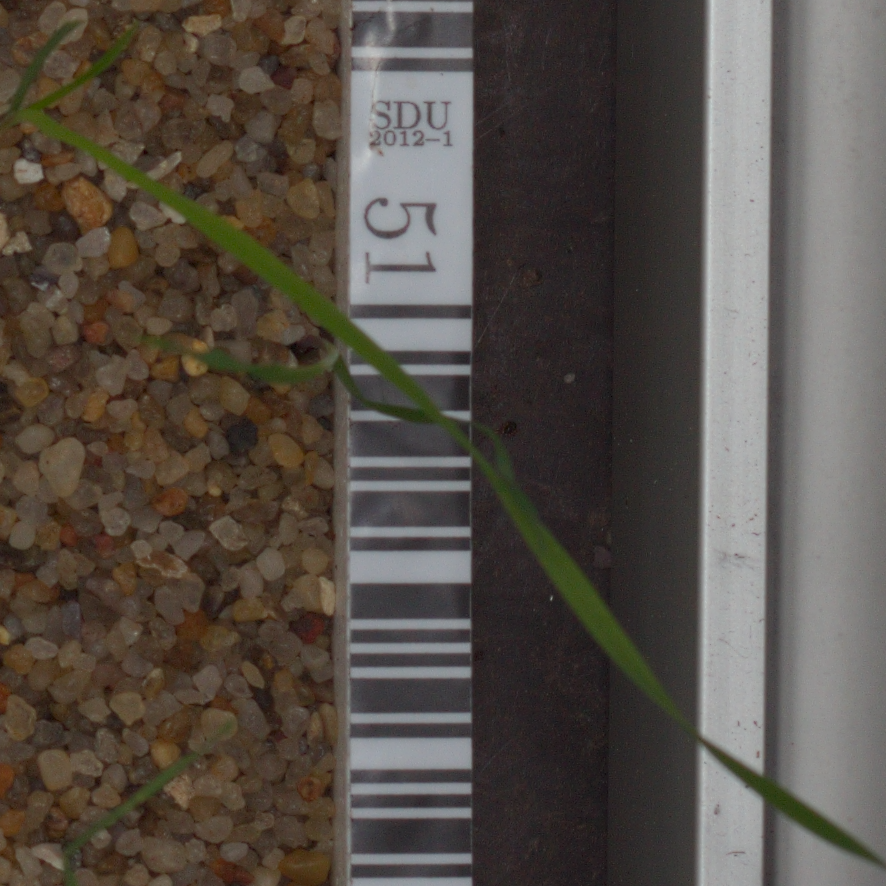

In [3]:
# Abre la imagen usando una ruta adecuada para Windows
img_color = Image.open(glob.glob(f"..\\resources/train\\*\\{IDS[2]}")[0])

# Imprime la cantidad de canales de color y la forma de la imagen
print(f"Tiene 3 colores {np.array(img_color).shape}")

# Muestra la imagen
img_color

In [4]:
def plot_1_images(d, label, ax=None):
    # Inicializa fig como None (esto se usa si no se proporciona un eje para graficar)
    fig = None

    # Si no se ha proporcionado un objeto de eje (`ax`), crea una nueva figura y un eje.
    if ax is None:
        fig, ax = plt.subplots(1, 1, constrained_layout=True)

    # Muestra la imagen `d` en el eje especificado
    ax.imshow(d)

    # Establece el título del gráfico utilizando el valor de `label`
    ax.set_title(label=label)

    # Retorna la figura y el eje, para que puedan ser utilizados o modificados externamente
    return fig, ax

# Data PreProcessing
Aqui simplemente se agrega un redimensión para luego guardar en un np.array y se entrenado y testeado en regresión y cnn 

In [6]:
# Listas para almacenar características y etiquetas del modelo
X = []
y = []

# Preprocesamiento de cada imagen
for img in glob.glob("..\\resources/train\\*\\*"):
    
    # Extrae la etiqueta (nombre de la subcarpeta) y el identificador de la imagen (nombre del archivo)
    label = img.split("\\")[2]
    
    # Abre la imagen, la convierte a escala RGB y redimensiona
    im = Image.open(img).convert('RGB')
    img_resized = im.resize(desired_size)
    
    # Convertir la imagen redimensionada a un array de NumPy y agregar a la lista
    X.append(np.array(img_resized))
    y.append(label)



In [7]:
# Crear un arreglo de numpy de todas las imagenes
# X representa las imagenes unidimensionales
np.array(X).shape


(5406, 128, 128, 3)

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Sugar beet'}>)

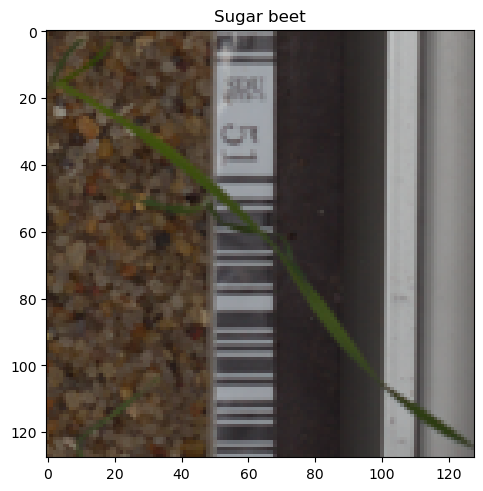

In [8]:
plot_1_images(X[2],label, ax=None)

In [16]:
# Convierte las etiquetas en formato de codificación one-hot (matriz binaria) para que puedan ser usadas en redes neuronales
y_img = to_categorical(le.transform(y))

# Redimensiona X para que se ajuste al formato requerido por una red neuronal convolucional (CNN).
X_img = np.reshape(np.array(X), (-1, desired_size[0], desired_size[1], n_channels)) 

# Divide los datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X_img, y_img, test_size=0.2) 

# Regresion logistica
Aqui se define los parametros de la regresión logistica

In [20]:
# Redimensiona y normaliza las imágenes de entrenamiento y prueba
# Primero, las imágenes de X_train se aplanan a un arreglo unidimensional
# y luego se normalizan dividiendo por 255 (para llevar los valores de píxeles a un rango [0, 1])
X_train_lg = np.reshape(X_train, (-1, desired_size[0] * desired_size[1] * n_channels)) * 1/255
X_test_lg = np.reshape(X_test, (-1, desired_size[0] * desired_size[1] * n_channels)) * 1/255

# Convierte las etiquetas `y_train` y `y_test` en índices de clases (vectores one-hot a índices)
# `np.argmax` selecciona el índice del valor máximo en cada fila, que corresponde a la clase correcta
y_train_lg = np.argmax(y_train, axis=1)
y_test_lg = np.argmax(y_test, axis=1)

# Inicializa el clasificador de regresión logística con los siguientes parámetros:
# - random_state=0: asegura la reproducibilidad del modelo
# - solver='lbfgs': usa el algoritmo 'lbfgs' (un optimizador de gradiente de segunda orden)
# - max_iter=5000: establece el número máximo de iteraciones del algoritmo de optimización
# - penalty='l2': utiliza regularización L2 (penalización en los pesos)
# - C=0.1: establece el valor de regularización (C es el inverso de la fuerza de regularización)
clf = LogisticRegression(random_state=0,
                         solver='lbfgs', max_iter=5000,
                         penalty='l2', C=0.1)

# Entrena el clasificador con las características de entrenamiento (X_train_lg) y las etiquetas (y_train_lg)
clf.fit(X_train_lg, y_train_lg)

LogisticRegression(C=0.1, max_iter=5000, random_state=0)

<Axes: >

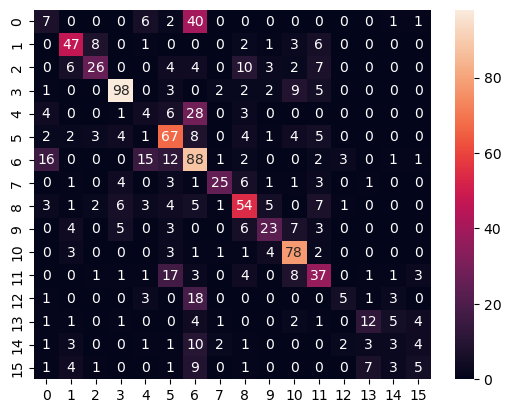

In [22]:
cm = confusion_matrix(y_test_lg, clf.predict(X_test_lg))
sns.heatmap(cm, annot=True, fmt='g')

In [23]:
accuracy_score(y_test_lg, clf.predict(X_test_lg))

0.5351201478743068

In [26]:
# Lista para almacenar las imágenes procesadas en el conjunto de prueba (test)
X_oob = []

# Lista para almacenar los nombres o identificadores de los archivos de imagen en el conjunto de prueba
file_oob = []

# Preprocesamiento de cada imagen
for img in glob.glob("..\\resources/test\\*"):
    
    # Extrae la etiqueta (nombre de la subcarpeta) y el identificador de la imagen (nombre del archivo)
    label = img.split("\\")[2]
    
    # Abre la imagen, la convierte a escala RGB y redimensiona a 64x64
    im = Image.open(img).convert('RGB')
    img_resized = im.resize(desired_size)

    # Convierte la imagen redimensionada en un arreglo numpy 1D (plano) y lo añade a la lista X_oob
    X_oob.append(np.array(img_resized))
    
    # Extrae el nombre o identificador del archivo desde la ruta y lo añade a la lista file_oob
    # Se asume que el identificador está en la tercera posición de la ruta (ajusta si es necesario)
    file_oob.append(img.split("\\")[2])
    

In [28]:
X_sub_lg = np.reshape(X_oob, (-1, desired_size[0]*desired_size[1]*n_channels))*1/255
df_oob = pd.DataFrame(data= zip(file_oob, le.inverse_transform(clf.predict(X_test_lg))),
                        columns=["file","label"])

In [30]:
df_oob.to_csv("regresion.csv", index=False)

In [32]:
# Refrescar memoria
X_train_lg = X_test_lg = y_train_lg = y_test_lg = None

# CNN
En esta parte se definen las capas del cnn

In [20]:
# Construcción del modelo CNN
model = Sequential()

# Definir la capa de entrada
model.add(Input(shape=(desired_size[0], desired_size[1], n_channels)))

# Primera capa convolucional
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Segunda capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Tercera capa convolucional
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Aplanamiento de las características y capas densas
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida para 16 clases
model.add(Dense(16, activation='softmax'))

# Compilación del modelo con pérdida para clasificación multiclase
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definimos el early stopping para detener el entrenamiento cuando no haya mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
# Entrenamiento del modelo
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 708ms/step - accuracy: 0.0879 - loss: 31.2247 - val_accuracy: 0.2335 - val_loss: 2.6861
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 700ms/step - accuracy: 0.1431 - loss: 2.6855 - val_accuracy: 0.2751 - val_loss: 2.5760
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 77s 708ms/step - accuracy: 0.2168 - loss: 2.5500 - val_accuracy: 0.3191 - val_loss: 2.3863
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 698ms/step - accuracy: 0.2705 - loss: 2.4124 - val_accuracy: 0.3364 - val_loss: 2.2988
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 697ms/step - accuracy: 0.2998 - loss: 2.2841 - val_accuracy: 0.3653 - val_loss: 2.1494
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 83s 703ms/step - accuracy: 0.3143 - loss: 2.1713 - val_accuracy: 0.3988 - val_loss: 2.0076
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 697ms/step - accuracy: 0.3469 - loss: 2.0740 - val_accuracy: 0.3769 - val_loss: 2.0312
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 76s 702ms/step - accuracy: 0.3655 - loss: 

In [28]:
X_oob_img = np.reshape(np.array(X_oob), (-1, desired_size[0], desired_size[1], n_channels))
y_hat = le.inverse_transform(np.argmax(model.predict(X_oob_img), axis=1))
df_oob = pd.DataFrame(data= zip(file_oob, y_hat),
                        columns=["file","label"])
df_oob.to_csv("cnn.csv", index=False)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
